In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks import *
sys.path.append('..')
from audio import *

In [5]:
#To have reproducible results with fastai you must also set num_workers=1 in your databunch, and seed=seed
#in split_by_rand_pct
seed = 42
# python RNG
random.seed(seed)
# pytorch RNGs
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
# numpy RNG
np.random.seed(seed)

## Introduction

In this notebook we will be using the library to compete in the [Google Brain Tensorflow Speech Challenge](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/), a kaggle competition that ended ~1 year ago. The goal of the competition is to recognize one-word commands, like stop, go, up, down...etc It was highly competitive so, in order to finish high, we will need to use more advanced techniques, which is a great opportunity to show how to use a variety of FastAI Audio features. Our approach will be as follows

- Pre-step: Algorithmically generating different types of noise for the "silence (no word)" class
- Base model 1: Mel Frequency Cepstral Coefficient (MFCC) along with delta and accelerate (1st and 2nd derivatives of MFCC) appended in the 2nd and 3rd channels
- Base model 2: Melspectrogram from scratch (no pretraining)
- Use base models to predict on the test set, and pseudolabel (semi-supervised learning) the test set where at least one model is extremely confident (> 99.9%).
- Fine tune both models on the original training data + pseudolabeled data.
- Pseudolabel again, using a lower threshold (at least one model 97.5% confident), and fine tune both models some more.
- Ensemble (use both models to make our final predictions)

Note that the first step here should always be EDA (exploratory data analysis) and getting to know the test/train set and how they differ. This is a tutorial designed to demonstrate audio techniques, so we are skipping EDA, but I will try to mention data discrepencies I found as they related to specific design choices.

There is still a lot of room to make changes and get even better results. Many of my design choices were arbitrary and didn't involve a huge amount of experimentation with the possible options, so do not in any way consider this authoritative. If you have an idea for a different route, test it and then tell us about it in the audio thread if it works (and especially if it doesn't, we all should be sharing negative results as well). 

## Grabbing the dataset

##### Note: this is a large dataset, containing ~65000 files for training and ~158000 for testing. 3.76GB in total

The following is directly from the 2019 Part 1, lesson 3 Planet Notebook from fastai, adjusted for our purposes.

The googlespeech dataset isn't available on the [fastai dataset page](https://course.fast.ai/datasets) but you can download it from Kaggle. Let's see how to do this by using the [Kaggle API](https://github.com/Kaggle/kaggle-api) as it's going to be pretty useful to you if you want to join a competition or use other Kaggle datasets later on.

First, install the Kaggle API by uncommenting the following line and executing it, or by executing it in your terminal (depending on your platform you may need to modify this slightly to either add `source activate fastai` or similar, or prefix `pip` with a path. Have a look at how `conda install` is called for your platform in the appropriate *Returning to work* section of https://course.fast.ai/. (Depending on your environment, you may also need to append "--user" to the command.)

In [6]:
! pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /opt/anaconda3/lib/python3.7/site-packages (1.5.4)


Then you need to upload your credentials from Kaggle on your instance. Login to kaggle and click on your profile picture on the top left corner, then 'My account'. Scroll down until you find a button named 'Create New API Token' and click on it. This will trigger the download of a file named 'kaggle.json'.

Upload this file to the directory this notebook is running in, by clicking "Upload" on your main Jupyter page, then uncomment and execute the next two commands (or run them in a terminal). For Windows, uncomment the last two commands.

In [7]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/

# For Windows, uncomment these two commands
# ! mkdir %userprofile%\.kaggle
# ! move kaggle.json %userprofile%\.kaggle

mv: cannot stat 'kaggle.json': No such file or directory


You're all set to download the data from [TensorFlow  Speech Recognition Challenge](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/). You **first need to go to its main page and accept its rules**, and run the two cells below (uncomment the shell commands to download and unzip the data). If you get a `403 forbidden` error it means you haven't accepted the competition rules yet (you have to go to the competition page, click on *Rules* tab, and then scroll to the bottom to find the *accept* button).

In [11]:
path = Path('../data/google_speech')
path.mkdir(parents=True, exist_ok=True)
! kaggle competitions download -c tensorflow-speech-recognition-challenge -p {path}

  0%|                                                | 0.00/501k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 501k/501k [00:00<00:00, 91.0MB/s]
 98%|█████████████████████████████████████▍| 1.03G/1.04G [00:10<00:00, 39.7MB/s]
100%|███████████████████████████████████████| 1.04G/1.04G [00:10<00:00, 107MB/s]
100%|██████████████████████████████████████▊| 2.45G/2.46G [00:23<00:00, 168MB/s]
100%|███████████████████████████████████████| 2.46G/2.46G [00:23<00:00, 114MB/s]
  0%|                                                | 0.00/50.0 [00:00<?, ?B/s]
100%|████████████████████████████████████████| 50.0/50.0 [00:00<00:00, 44.7kB/s]


To extract the content of this file, we'll need 7zip, so uncomment the following line if you need to install it (or run `sudo apt install p7zip-full` in your terminal).

In [9]:
! conda install -y -c haasad eidl7zip

Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - eidl7zip


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.7.5                |           py37_0         3.0 MB
    conda-package-handling-1.3.11|           py37_0         260 KB
    eidl7zip-1.0.0             |                1         565 KB  haasad
    ------------------------------------------------------------
                                           Total:         3.8 MB

The following NEW packages will be INSTALLED:

  conda-package-han~ pkgs/main/linux-64::conda-package-handling-1.3.11-py37_0
  eidl7zip           haasad/linux-64::eidl7zip-1.0.0-1

The following packages will be UPDATED:

  conda                                        4.6.8-py37_0 --> 4.7.5-py37_0



eidl7zip-1.0.0       | 565 KB    | ##################################### | 100% 
conda-4.

And now we can unpack the data (uncomment to run - this will take quite a long time to run for the testset).

In [ ]:
# ! 7za -o{path} x {path}/train.7z 
# ! 7za -o{path} x {path}/test.7z 

## Organizing the data

In [23]:
PATH_BASE = Path('../data/google_speech/')
PATH_TEST = PATH_BASE/'test/'
PATH_TRAIN = PATH_BASE/'train/audio/'

The data supplied isn't actually what we need to begin training. Below we will see all the data we just downloaded, 20 or so words, but the 12 classes are 'up', 'down', 'yes', 'no', 'left', 'right', 'stop', 'go', 'on', 'off', 'silence', and 'unknown'. This means we need to copy all the words that don't have their own class into 'unknown'. Normally I would do this in a separate folder in case I needed to come back and grab the originals, but for memory's sake we will do it here in one go.

In [27]:
commands = 'up down yes no left right stop go on off silence unknown'.split()
folders = [str(x).split('/')[-1] for x in PATH_TRAIN.ls()]
commands, folders

(['up',
  'down',
  'yes',
  'no',
  'left',
  'right',
  'stop',
  'go',
  'on',
  'off',
  'silence',
  'unknown'],
 ['zero',
  'stop',
  'nine',
  'off',
  '_background_noise_',
  'on',
  'tree',
  'eight',
  'three',
  'two',
  'yes',
  'seven',
  'right',
  'bed',
  'six',
  'wow',
  'happy',
  'five',
  'bird',
  'house',
  'cat',
  'marvin',
  'no',
  'left',
  'sheila',
  'go',
  'dog',
  'up',
  'down',
  'four',
  'one'])

In [25]:
PATH_TRAIN.ls()

[PosixPath('../data/google_speech/train/audio/zero'),
 PosixPath('../data/google_speech/train/audio/stop'),
 PosixPath('../data/google_speech/train/audio/nine'),
 PosixPath('../data/google_speech/train/audio/off'),
 PosixPath('../data/google_speech/train/audio/_background_noise_'),
 PosixPath('../data/google_speech/train/audio/on'),
 PosixPath('../data/google_speech/train/audio/tree'),
 PosixPath('../data/google_speech/train/audio/eight'),
 PosixPath('../data/google_speech/train/audio/three'),
 PosixPath('../data/google_speech/train/audio/two'),
 PosixPath('../data/google_speech/train/audio/yes'),
 PosixPath('../data/google_speech/train/audio/seven'),
 PosixPath('../data/google_speech/train/audio/right'),
 PosixPath('../data/google_speech/train/audio/bed'),
 PosixPath('../data/google_speech/train/audio/six'),
 PosixPath('../data/google_speech/train/audio/wow'),
 PosixPath('../data/google_speech/train/audio/happy'),
 PosixPath('../data/google_speech/train/audio/five'),
 PosixPath('../da

In [9]:
sg_cfg= SpectrogramConfig(hop=126, n_mels=224, n_fft=1028, f_max=8000, top_db=80, f_min=20)
cfg = AudioConfig(cache=True, max_to_pad=1003, resample_to=16000, mfcc=False, delta=False, sg_cfg=sg_cfg)
sg_cfg

SpectrogramConfig(f_min=20, f_max=8000, hop=126, n_fft=1028, n_mels=224, pad=0, to_db_scale=True, top_db=80, ws=None, n_mfcc=20)

In [10]:
data_pct = 0.001
al_train = AudioList.from_folder(PATH_CLEAN, config=cfg).use_partial_data(data_pct).split_by_rand_pct(0.2, seed=seed).label_from_folder()

In [11]:
al_train.train[0][0].shape

torch.Size([3, 224, 128])

In [12]:
tfms = get_spectro_transforms(roll=False)

In [13]:
db_audio = al_train.transform(None).databunch(bs=32)

------------------------------------------------------------
File: /home/jupyter/rob/googlespeech/train/cleanaudio/.cache/rs_16000/six-7846fd85_nohash_1.wav-d577a9683ec94f825cf9754fb46b97bf/0.wav
Total Length: 1.0 seconds
Label: unknown


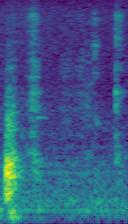

------------------------------------------------------------
File: /home/jupyter/rob/googlespeech/train/cleanaudio/.cache/rs_16000/no-7b301939_nohash_1.wav-dbd82da86f2a56e054e0822091ea2f05/0.wav
Total Length: 1.0 seconds
Label: no


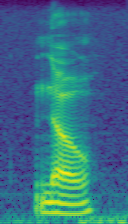

------------------------------------------------------------
File: /home/jupyter/rob/googlespeech/train/cleanaudio/.cache/rs_16000/five-c245d3d7_nohash_0.wav-800ad4605a890a1aacf72aed277078d2/0.wav
Total Length: 1.0 seconds
Label: unknown


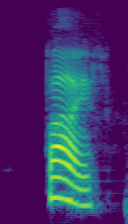

In [14]:
db_audio.show_batch()

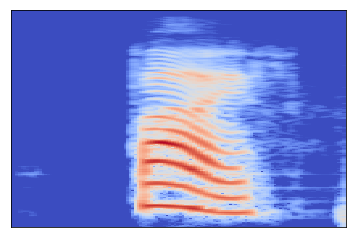

In [15]:
y,sr = librosa.load('/home/jupyter/rob/googlespeech/train/cleanaudio/.cache/rs_16000/five-c245d3d7_nohash_0.wav-800ad4605a890a1aacf72aed277078d2/0.wav', sr=16000)
librosa.display.specshow(librosa.power_to_db(librosa.feature.melspectrogram(y, hop_length=126, n_mels=224, n_fft=1028, fmax=None)))